In [18]:
train_dir =  "/content/drive/MyDrive/Tumour/train"
test_dir   = "/content/drive/MyDrive/Tumour/test"
val_dir  = "/content/drive/MyDrive/Tumour/valid"



Tumor Categories: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


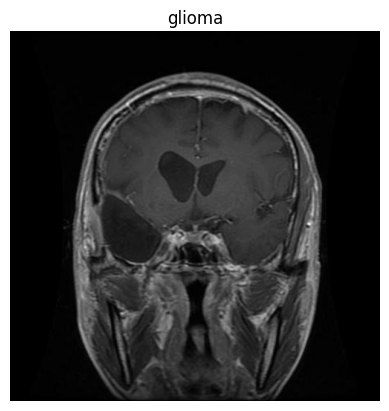

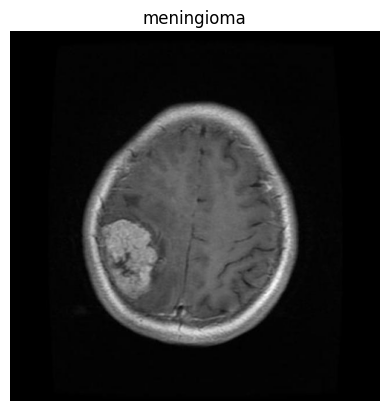

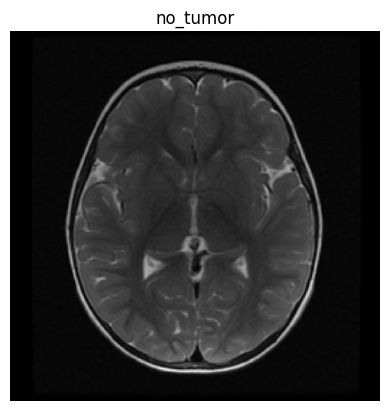

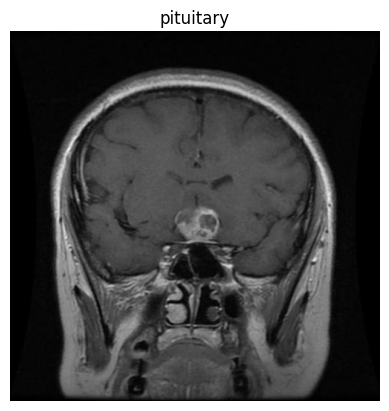

In [19]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_dir = "/content/drive/MyDrive/Tumour/train"

# ✅ Only keep class folders (skip classes.csv or any file)
categories = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
print("Tumor Categories:", categories)

# ✅ Show one image from each class folder
for category in categories:
    category_path = os.path.join(train_dir, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:  # Only proceed if images are present
        img_path = os.path.join(category_path, image_files[0])
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
        plt.show()


{'glioma': 564, 'meningioma': 358, 'no_tumor': 335, 'pituitary': 438}

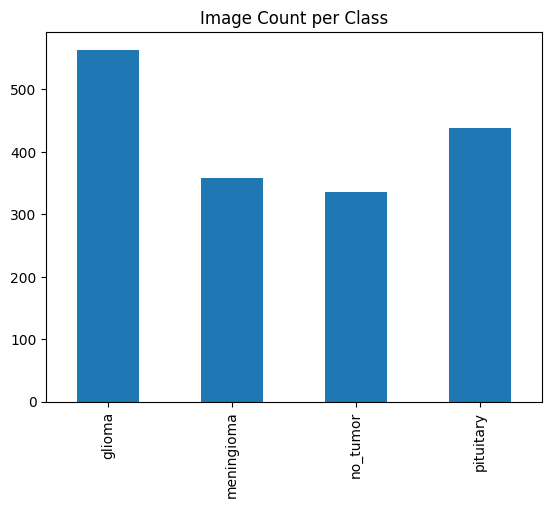

In [20]:
import pandas as pd

image_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in categories}
pd.Series(image_counts).plot(kind='bar', title='Image Count per Class')
image_counts


In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_names = list(image_counts.keys())
class_indices = {name: i for i, name in enumerate(class_names)}

# Flatten class labels based on image counts
y_train = []
for class_name in class_names:
    y_train.extend([class_indices[class_name]] * image_counts[class_name])

# Compute weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(class_names))}

print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.7513297872340425), 1: np.float64(1.183659217877095), 2: np.float64(1.2649253731343284), 3: np.float64(0.9674657534246576)}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

test_dir   = "/content/drive/MyDrive/Tumour/test"
val_dir  = "/content/drive/MyDrive/Tumour/valid"

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [ ]:
from tensorflow.keras import layers, models

custom_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.BatchNormalization(),  # helps stabilize training
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # reduces overfitting
    layers.Dense(4, activation='softmax')  # 4 classes
])

custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model initially

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(4, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_cnn = ModelCheckpoint('cnn_best.h5', save_best_only=True)
checkpoint_mobilenet = ModelCheckpoint('mobilenet_best.h5', save_best_only=True)

# Train Custom CNN
history_cnn = custom_cnn.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint_cnn],
    class_weight=class_weights  # if you're using class weights
)

# Train Transfer Learning Model
history_mobilenet = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint_mobilenet],
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4807 - loss: 3.0217 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 1186s 22s/step - accuracy: 0.4817 - loss: 2.9982 - val_accuracy: 0.4163 - val_loss: 1.3459
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.6341 - loss: 0.9359 - val_accuracy: 0.3486 - val_loss: 1.3712
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6488 - loss: 0.9243

53/53 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.6488 - loss: 0.9241 - val_accuracy: 0.3127 - val_loss: 1.3176
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6773 - loss: 0.8097

53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.6771 - loss: 0.8105 - val_accuracy: 0.4223 - val_loss: 1.2729
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6991 - loss: 0.7909

53/53 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.6991 - loss: 0.7911 - val_accuracy: 0.5040 - val_loss: 1.1616
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7437 - loss: 0.7459

53/53 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.7432 - loss: 0.7462 - val_accuracy: 0.7211 - val_loss: 1.0375
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7298 - loss: 0.7194

53/53 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7294 - loss: 0.7200 - val_accuracy: 0.6873 - val_loss: 0.9923
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7171 - loss: 0.7101 - val_accuracy: 0.3347 - val_loss: 1.1393
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7141 - loss: 0.7254

53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7144 - loss: 0.7251 - val_accuracy: 0.6494 - val_loss: 0.7940
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7152 - loss: 0.7315

53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7155 - loss: 0.7309 - val_accuracy: 0.7769 - val_loss: 0.6981
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7399 - loss: 0.6667 - val_accuracy: 0.4044 - val_loss: 1.5604
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7664 - loss: 0.6600

53/53 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7661 - loss: 0.6606 - val_accuracy: 0.8127 - val_loss: 0.5451
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7420 - loss: 0.6356 - val_accuracy: 0.6853 - val_loss: 0.8754
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7547 - loss: 0.6406 - val_accuracy: 0.7410 - val_loss: 0.6178
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7758 - loss: 0.6143

53/53 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.7757 - loss: 0.6144 - val_accuracy: 0.8147 - val_loss: 0.5416
Epoch 16/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7808 - loss: 0.5757 - val_accuracy: 0.5538 - val_loss: 1.3847
Epoch 17/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7606 - loss: 0.6182 - val_accuracy: 0.4422 - val_loss: 1.5835
Epoch 18/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7675 - loss: 0.6271 - val_accuracy: 0.7749 - val_loss: 0.6620
Epoch 19/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7706 - loss: 0.6065 - val_accuracy: 0.7928 - val_loss: 0.6232
Epoch 20/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7831 - loss: 0.5288 - val_accuracy: 0.6056 - val_loss: 1.0916
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5567 - loss: 1.1368

53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5587 - loss: 1.1317 - val_accuracy: 0.7112 - val_loss: 0.6553
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8153 - loss: 0.5079

53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8153 - loss: 0.5077 - val_accuracy: 0.8167 - val_loss: 0.4895
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8404 - loss: 0.4580

53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8406 - loss: 0.4573 - val_accuracy: 0.8327 - val_loss: 0.4802
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8546 - loss: 0.3992

53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8547 - loss: 0.3989 - val_accuracy: 0.8486 - val_loss: 0.4350
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8654 - loss: 0.3622 - val_accuracy: 0.7988 - val_loss: 0.5284
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8752 - loss: 0.3626 - val_accuracy: 0.8446 - val_loss: 0.4519
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8891 - loss: 0.2977 - val_accuracy: 0.8347 - val_loss: 0.4962
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8970 - loss: 0.2916 - val_accuracy: 0.8187 - val_loss: 0.5165
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9058 - loss: 0.2712 - val_accuracy: 0.8446 - val_loss: 0.4388


Custom CNN Evaluation:


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 123s 17s/step
              precision    recall  f1-score   support

      glioma       0.81      0.96      0.88        80
  meningioma       0.85      0.52      0.65        63
    no_tumor       0.87      0.84      0.85        49
   pituitary       0.77      0.93      0.84        54

    accuracy                           0.82       246
   macro avg       0.82      0.81      0.81       246
weighted avg       0.82      0.82      0.81       246



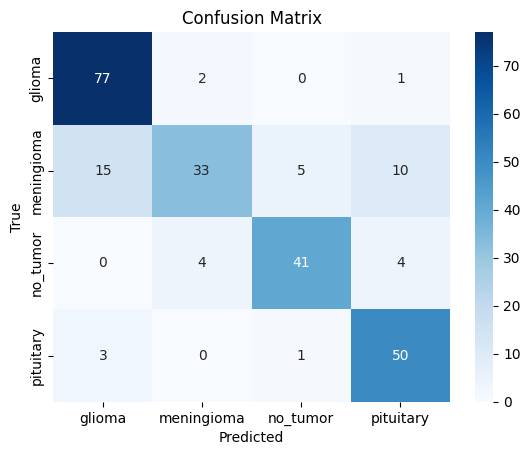

Transfer Learning (MobileNetV2) Evaluation:
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 933ms/step
              precision    recall  f1-score   support

      glioma       0.96      0.88      0.92        80
  meningioma       0.82      0.67      0.74        63
    no_tumor       0.88      0.86      0.87        49
   pituitary       0.73      1.00      0.84        54

    accuracy                           0.85       246
   macro avg       0.85      0.85      0.84       246
weighted avg       0.86      0.85      0.84       246



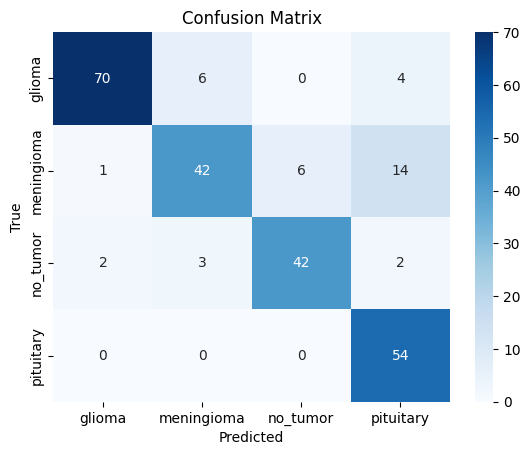

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_data):
    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_data.classes
    labels = list(test_data.class_indices.keys())

    print(classification_report(y_true, y_pred, target_names=labels))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("Custom CNN Evaluation:")
evaluate_model(custom_cnn, test_data)

print("Transfer Learning (MobileNetV2) Evaluation:")
evaluate_model(mobilenet_model, test_data)


In [ ]:
mobilenet_model.save('/content/drive/MyDrive/mobilenetv2_brain_tumor.h5')


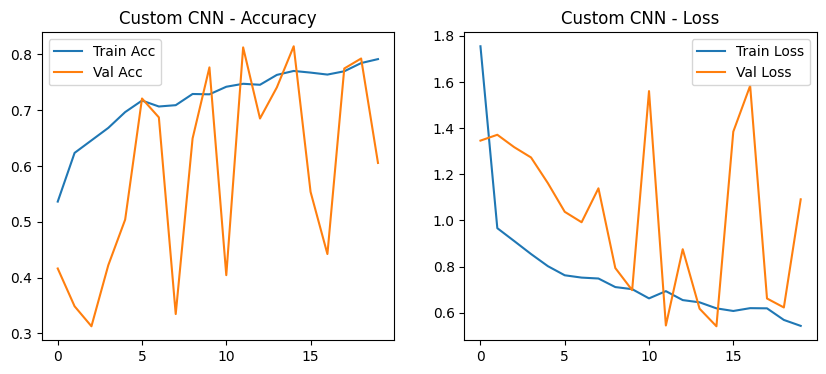

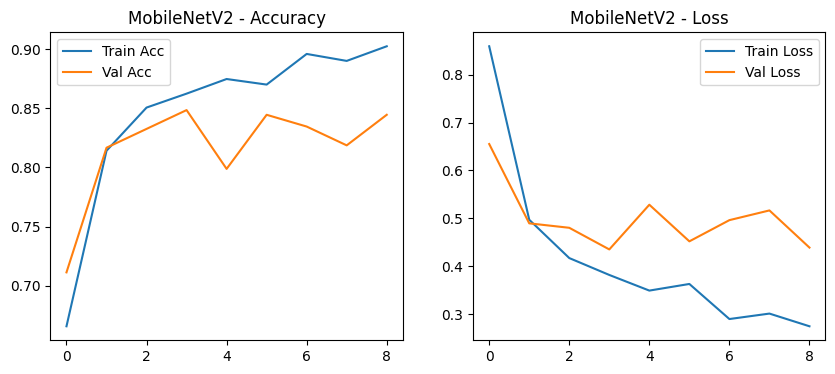

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(10,4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title + " - Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title + " - Loss")
    plt.legend()

    plt.show()

plot_history(history_cnn, "Custom CNN")
plot_history(history_mobilenet, "MobileNetV2")


In [ ]:


from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/mobilenetv2_brain_tumor.h5")


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 730ms/step - accuracy: 0.8325 - loss: 0.5497
Test Accuracy: 0.85


In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [10]:


mobilenet_model = load_model("/content/drive/MyDrive/mobilenetv2_brain_tumor.h5")


In [11]:
mobilenet_model.layers[0].trainable = True  # unfreeze base MobileNetV2


In [14]:
from tensorflow.keras.optimizers import Adam

mobilenet_model.compile(
    optimizer=Adam(1e-5),  # smaller learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint_mobilenet = ModelCheckpoint(
    "/content/drive/MyDrive/mobilenetv2_brain_tumor.h5",  # Save path
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)


In [22]:
fine_tune_history = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, checkpoint_mobilenet],
    class_weight=class_weights  # if using
)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8796 - loss: 0.3525

53/53 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8797 - loss: 0.3521 - val_accuracy: 0.8486 - val_loss: 0.4388
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8886 - loss: 0.3063

53/53 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8885 - loss: 0.3065 - val_accuracy: 0.8486 - val_loss: 0.4368
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8959 - loss: 0.2979

53/53 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8958 - loss: 0.2981 - val_accuracy: 0.8506 - val_loss: 0.4346
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8849 - loss: 0.3421 - val_accuracy: 0.8466 - val_loss: 0.4355
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8924 - loss: 0.3095

53/53 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.8925 - loss: 0.3093 - val_accuracy: 0.8526 - val_loss: 0.4325
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8858 - loss: 0.3312 - val_accuracy: 0.8486 - val_loss: 0.4373
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9041 - loss: 0.3078 - val_accuracy: 0.8486 - val_loss: 0.4332
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8991 - loss: 0.2962

53/53 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8991 - loss: 0.2962 - val_accuracy: 0.8526 - val_loss: 0.4295
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9044 - loss: 0.2924

53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9043 - loss: 0.2925 - val_accuracy: 0.8526 - val_loss: 0.4259
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8908 - loss: 0.3000 - val_accuracy: 0.8486 - val_loss: 0.4312


In [25]:
from tensorflow.keras.models import load_model


model = load_model("/content/drive/MyDrive/mobilenetv2_brain_tumor.h5")
model.evaluate(test_data)  # See if accuracy ~0.85–0.90



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 0.8168 - loss: 0.5192


[0.4749402403831482, 0.8211382031440735]

In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Step 1: Load your best model
model = load_model("/content/drive/MyDrive/mobilenetv2_brain_tumor.h5")

# Step 2: Unfreeze the base model (MobileNetV2 is usually the first layer)
base_model = model.layers[0]
base_model.trainable = True

# Step 3: Recompile with a very low learning rate
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Optional: Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

fine_tune_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/mobilenetv2_finetuned.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 4: Continue training (fine-tune)
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, fine_tune_checkpoint],
    class_weight=class_weights  # only if you used class weighting earlier
)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8996 - loss: 0.2864
Epoch 1: val_loss improved from inf to 0.42598, saving model to /content/drive/MyDrive/mobilenetv2_finetuned.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.8996 - loss: 0.2864 - val_accuracy: 0.8526 - val_loss: 0.4260
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9018 - loss: 0.2749
Epoch 2: val_loss did not improve from 0.42598
53/53 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9015 - loss: 0.2756 - val_accuracy: 0.8506 - val_loss: 0.4286
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8932 - loss: 0.2839
Epoch 3: val_loss did not improve from 0.42598
53/53 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.8932 - loss: 0.2843 - val_accuracy: 0.8526 - val_loss: 0.4317
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9071 - loss: 0.2737
Epoch 4: val_loss did not improve from 0.42598
53/53 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9069 - loss: 0.2742 - val_accuracy: 0.8506 - val_loss: 0.4339
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9031 - loss: 0.3042
Epoch 5: val_loss did not improve from 0.42598
53/53 ━━━━━━━━━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8964 - loss: 0.2914 - val_accuracy: 0.8546 - val_loss: 0.4244
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8934 - loss: 0.2982
Epoch 7: val_loss did not improve from 0.42439
53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.8935 - loss: 0.2977 - val_accuracy: 0.8466 - val_loss: 0.4322
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9096 - loss: 0.2813
Epoch 8: val_loss did not improve from 0.42439
53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9095 - loss: 0.2814 - val_accuracy: 0.8486 - val_loss: 0.4310
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8847 - loss: 0.3017
Epoch 9: val_loss did not improve from 0.42439
53/53 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8849 - loss: 0.3016 - val_accuracy: 0.8486 - val_loss: 0.4281
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9101 - loss: 0.2892
Epoch 10: val_loss did not improve from 0.42439
53/53 ━━━━━━━━

In [27]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/mobilenetv2_finetuned.h5")
model.evaluate(test_data)


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8203 - loss: 0.5165


[0.47439199686050415, 0.8211382031440735]